In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

# print('# File sizes')
# for f in os.listdir('../input'):
#     if 'zip' not in f:
#         print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

## Dataset Split

In [62]:
df = pd.read_csv('data/train.csv')
df_test = df.sample(frac=0.3)
df_train = df[~df.index.isin(df_test.index)]
df = df.reset_index()
df_test = df_test.reset_index()
df_test = df_test.drop(['index','id'],axis=1)
df_test.insert(0,'test_id',df_test.index)
df_test.head(5)

,test_id,qid1,qid2,question1,question2,is_duplicate
0,0,161079,161080,What are the steps for removing spray paint fr...,How do you remove spray paint from cement?,1
1,1,84118,84119,What are some examples of a catalyst in a chem...,What are the catalysts used in chemical reacti...,0
2,2,11212,4121,Why is Saltwater taffy candy imported in The B...,Why is Saltwater taffy candy imported in Japan?,1
3,3,511710,511711,How do you console a distant relative whose yo...,How can I and my family adopt a useful therapy...,0
4,4,414621,195203,Is there a way to get download statistics from...,Where do the downloaded songs get saved on the...,0


In [63]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [64]:
if len(df) == len(df_test)+len(df_train):
    print('True.')
len(df_test)/len(df)

True.


0.3

## Test Submission

In [65]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

# df_test = pd.read_csv('data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score: 0.6587935431892127


,test_id,is_duplicate
0,0,0.369696
1,1,0.369696
2,2,0.369696
3,3,0.369696
4,4,0.369696


## Test Set

In [66]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 121287


Nothing out of the ordinary here. We are once again given rowIDs and the textual data of the two questions. It is worth noting that we are not given question IDs here however for the two questions in the pair.

It is also worth pointing out that the actual number of test rows are likely to be much lower than 2.3 million. According to the [data page](https://www.kaggle.com/c/quora-question-pairs/data), most of the rows in the test set are using auto-generated questions to pad out the dataset, and deter any hand-labelling. This means that the true number of rows that are scored could be very low.

We can actually see in the head of the test data that some of the questions are obviously auto-generated, as we get delights such as "How their can I start reading?" and "What foods fibre?". Truly insightful questions.

Now onto the good stuff - the text data!
## Text analysis

First off, some quick histograms to understand what we're looking at. **Most analysis here will be only on the training set, to avoid the auto-generated questions**

mean-train 59.85 std-train 31.92 mean-test 59.75 std-test 32.06 max-train 1169.00 max-test 1169.00


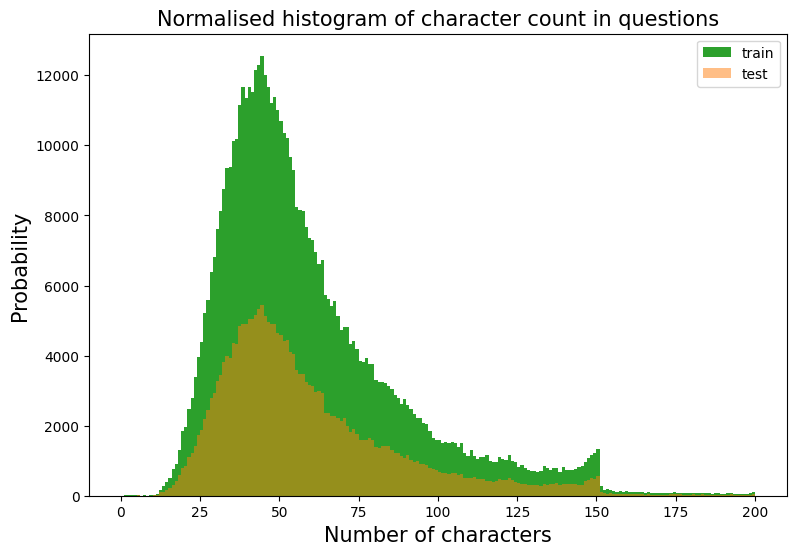

In [67]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(9, 6))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2],  label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1],  alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 11.07 std-train 5.88 mean-test 11.06 std-test 5.91 max-train 237.00 max-test 237.00


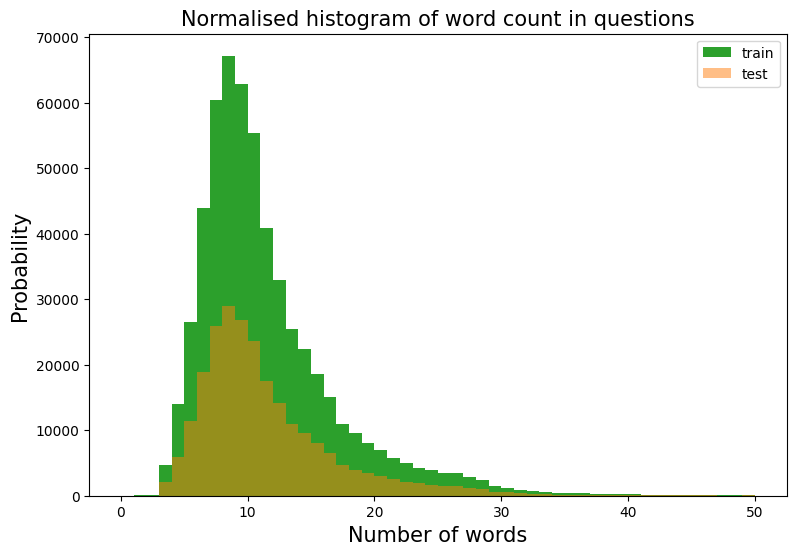

In [68]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(9, 6))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2],  label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1],  alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

## Semantic Analysis

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [69]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.29%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.75%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

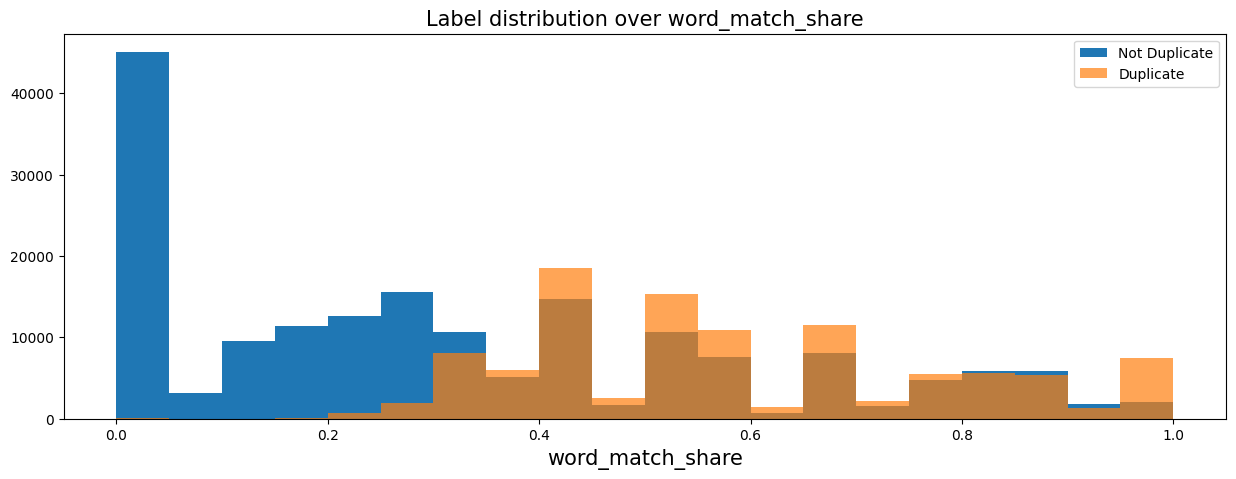

In [70]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [71]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [72]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 3.6512341171315907e-06), ('what', 4.388332302075242e-06), ('is', 5.0435256261537065e-06), ('how', 6.123323740126141e-06), ('i', 6.281801620704818e-06), ('a', 6.379381837899908e-06), ('to', 6.531934628398239e-06), ('in', 6.8230044417758916e-06), ('of', 8.2385216796698e-06), ('do', 8.471704506946798e-06)]

Least common words and weights: 


[('slits', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('nitk,', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('mannerism', 9.998000399920016e-05),
 ('gonulcelen', 9.998000399920016e-05),
 ('jaish-e-mohammad', 9.998000399920016e-05),
 ('(jem)', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05)]

In [73]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_1586/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


Text(0.5, 0, 'word_match_share')

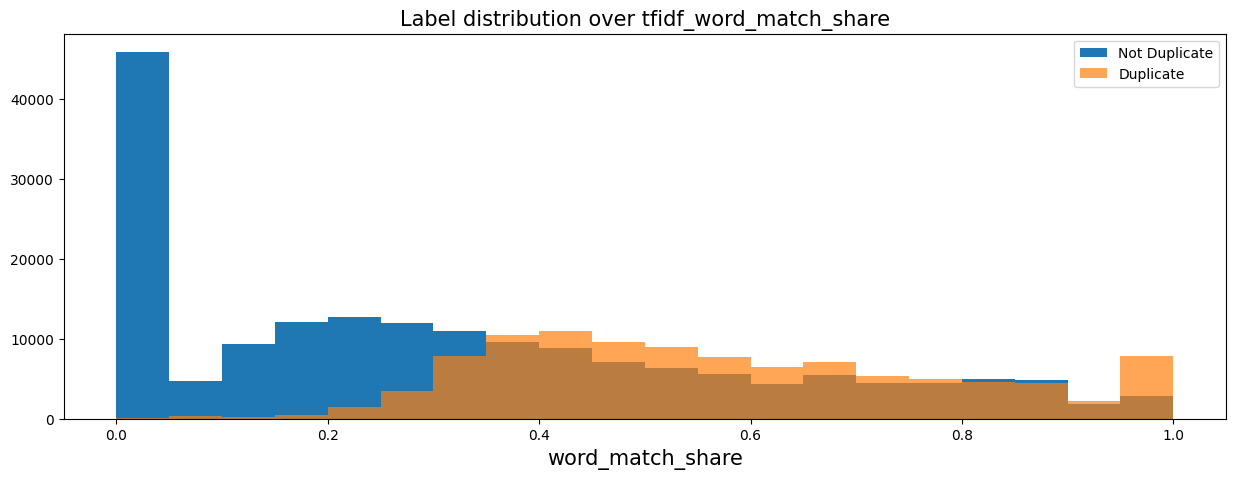

In [74]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [75]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7800723315968976
   TFIDF AUC: 0.7703792249107124


So it looks like our TF-IDF actually got _worse_ in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

## Rebalancing the Data
However, before I do this, I would like to rebalance the data that XGBoost receives, since we have 37% positive class in our training data, and only 17% in the test data. By re-balancing the data so our training set has 17% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [76]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1)

y_train = df_train['is_duplicate'].values

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_1586/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


In [78]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19119751319879608


In [79]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [80]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68323	valid-logloss:0.68323


/Users/panqiyang/mambaforge/envs/dl-mps/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	train-logloss:0.60244	valid-logloss:0.60241
[20]	train-logloss:0.54547	valid-logloss:0.54545
[30]	train-logloss:0.50390	valid-logloss:0.50387
[40]	train-logloss:0.47286	valid-logloss:0.47282
[50]	train-logloss:0.44929	valid-logloss:0.44924
[60]	train-logloss:0.43119	valid-logloss:0.43113
[70]	train-logloss:0.41716	valid-logloss:0.41710
[80]	train-logloss:0.40619	valid-logloss:0.40614
[90]	train-logloss:0.39757	valid-logloss:0.39753
[100]	train-logloss:0.39078	valid-logloss:0.39075
[110]	train-logloss:0.38537	valid-logloss:0.38534
[120]	train-logloss:0.38107	valid-logloss:0.38105
[130]	train-logloss:0.37766	valid-logloss:0.37766
[140]	train-logloss:0.37494	valid-logloss:0.37495
[150]	train-logloss:0.37277	valid-logloss:0.37278
[160]	train-logloss:0.37101	valid-logloss:0.37104
[170]	train-logloss:0.36958	valid-logloss:0.36961
[180]	train-logloss:0.36843	valid-logloss:0.36846
[190]	train-logloss:0.36750	valid-logloss:0.36754
[200]	train-logloss:0.36676	valid-logloss:0.36681
[210]	tra

In [103]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

threshold = 0.3

def pred_dup(row):
    if row['pred']<=threshold:
        return 0
    else:
        return 1

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['pred'] = p_test
sub['pred_duplicate'] = sub.apply(pred_dup, axis=1)
sub['is_duplicate'] = df_test['is_duplicate']
# sub.to_csv('simple_xgb.csv', index=False)
sub.head(5)

,test_id,pred,pred_duplicate,is_duplicate
0,0,0.381096,1,1
1,1,0.026516,0,0
2,2,0.291952,0,1
3,3,0.000319,0,0
4,4,0.000586,0,0


In [104]:
def is_correct(row):
    if row['pred_duplicate']==row['is_duplicate']:
        return 1
    else:
        return 0
    
sub['correct'] = sub.apply(is_correct,axis=1)
acc = sub['correct'].sum()/len(sub)
acc

0.7347118817350582